In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
#Data - Final Team Project
import pandas as pd

#Read each csv file
# Person 1 High Risk
dfp1h = pd.read_csv('drive/MyDrive/emgt/P2_High.csv', skiprows=5, low_memory=False, usecols=range(56))

# Person 1 Low Risk
dfp1l = pd.read_csv("drive/MyDrive/emgt/P1_Low.csv", skiprows=5, low_memory= False, usecols=range(56))

# Person 2 High Risk
dfp2h = pd.read_csv("drive/MyDrive/emgt/P1_High.csv", skiprows=5, low_memory=False, usecols=range(56))

# Person 2 Low Risk)
dfp2l = pd.read_csv("drive/MyDrive/emgt/P2_Low.csv", skiprows=5, low_memory=False, usecols=range(56))

# Ensure all columns are numeric
dfp1h = dfp1h.apply(pd.to_numeric, errors='coerce')
dfp1l = dfp1l.apply(pd.to_numeric, errors='coerce')
dfp2h = dfp2h.apply(pd.to_numeric, errors='coerce')
dfp2l = dfp2l.apply(pd.to_numeric, errors='coerce')

Open CSV files to check what they look like. Use skiprows=5 and low_memory=False to load it properly (the top 5 rows are metadata)

In [21]:
# RENAME THE SENSOR COLUMNS

# Person 1 High Risk
dfp1h.rename(columns={' EMG 1 (mV)': 'Sensor 1 (right bicep)'}, inplace=True)
dfp1h.rename(columns={' EMG 1 (mV).1': 'Sensor 2 (right delt)'}, inplace=True)
dfp1h.rename(columns={' EMG 1 (mV).2': 'Sensor 3 (left bicep)'}, inplace=True)
dfp1h.rename(columns={' EMG 1 (mV).3': 'Sensor 4 (left delt)'}, inplace=True)

# Person 1 Low Risk
dfp1l.rename(columns={' EMG 1 (mV)': 'Sensor 1 (right bicep)'}, inplace=True)
dfp1l.rename(columns={' EMG 1 (mV).1': 'Sensor 2 (right delt)'}, inplace=True)
dfp1l.rename(columns={' EMG 1 (mV).2': 'Sensor 3 (left bicep)'}, inplace=True)
dfp1l.rename(columns={' EMG 1 (mV).3': 'Sensor 4 (left delt)'}, inplace=True)

# Person 2 High Risk
dfp2h.rename(columns={' EMG 1 (mV)': 'Sensor 1 (right bicep)'}, inplace=True)
dfp2h.rename(columns={' EMG 1 (mV).1': 'Sensor 2 (right delt)'}, inplace=True)
dfp2h.rename(columns={' EMG 1 (mV).2': 'Sensor 3 (left bicep)'}, inplace=True)
dfp2h.rename(columns={' EMG 1 (mV).3': 'Sensor 4 (left delt)'}, inplace=True)

# Person 2 Low Risk
dfp2l.rename(columns={' EMG 1 (mV)': 'Sensor 1 (right bicep)'}, inplace=True)
dfp2l.rename(columns={' EMG 1 (mV).1': 'Sensor 2 (right delt)'}, inplace=True)
dfp2l.rename(columns={' EMG 1 (mV).2': 'Sensor 3 (left bicep)'}, inplace=True)
dfp2l.rename(columns={' EMG 1 (mV).3': 'Sensor 4 (left delt)'}, inplace=True)

4 EMG Sensors are used: Sensor 1 (right bicep), Sensor 2 (right delt), Sensor 3 (left bicep), Sensor 4 (left delt). Rename the sensor columns appropriately


In [22]:
import numpy as np
import pandas as pd

emg_columns = [
    "Sensor 1 (right bicep)",
    "Sensor 2 (right delt)",
    "Sensor 3 (left bicep)",
    "Sensor 4 (left delt)"
]

def extract_rolling_emg_features(df: pd.DataFrame, window_size: int = 100, step_size: int = 30) -> pd.DataFrame:
    n_samples = df.shape[0]
    feature_rows = []

    for start in range(0, n_samples - window_size + 1, step_size):
        window = df.iloc[start : start + window_size]
        row_feats = []
        for col in emg_columns:
            vals = window[col].to_numpy()
            row_feats += [
                vals.mean(), vals.max(), vals.min(),
                vals.std(), np.sqrt((vals**2).mean())
            ]
        feature_rows.append(row_feats)

    col_names = []
    for i in range(1, len(emg_columns) + 1):
        short = f"S{i}"
        col_names += [
            f"μ_EMG_{short}", f"Max_EMG_{short}", f"Min_EMG_{short}",
            f"Std_EMG_{short}", f"RMS_EMG_{short}"
        ]

    return pd.DataFrame(feature_rows, columns=col_names)

EMG Data preparation and Feature Extraction (Rolling Window Selection)

In [23]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

dfs = []

for df_trial, label in [
    (dfp1l, 0),  # LowRisk
    (dfp1h, 1),  # HighRisk
    (dfp2l, 0),  # LowRisk
    (dfp2h, 1)   # HighRisk
]:
    df_trial = df_trial.fillna(df_trial.mean())

    #Remove outliers by z-score clipping (±3σ)
    zs = np.abs(zscore(df_trial[emg_columns]))
    df_clean = df_trial[(zs < 3).all(axis=1)]

    # Standardize EMG measurements
    scaler = StandardScaler()
    df_scaled = df_clean.copy()
    df_scaled[emg_columns] = scaler.fit_transform(df_clean[emg_columns])
    # Extract features from the scaled signals
    feats = extract_rolling_emg_features(df_scaled)

    # Attach the label
    feats["Label"] = label
    dfs.append(feats)

# 5. Concatenate all trials
full_df = pd.concat(dfs, ignore_index=True)

# 6. Split into X & y
X = full_df.drop(columns="Label")
y = full_df["Label"].values

In [24]:
from sklearn.model_selection import train_test_split
# 70/30 split, stratified by label
x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,      # 30% test, 70% train
    stratify=y,          # keep same class balance
    random_state=42
)

Extract Features

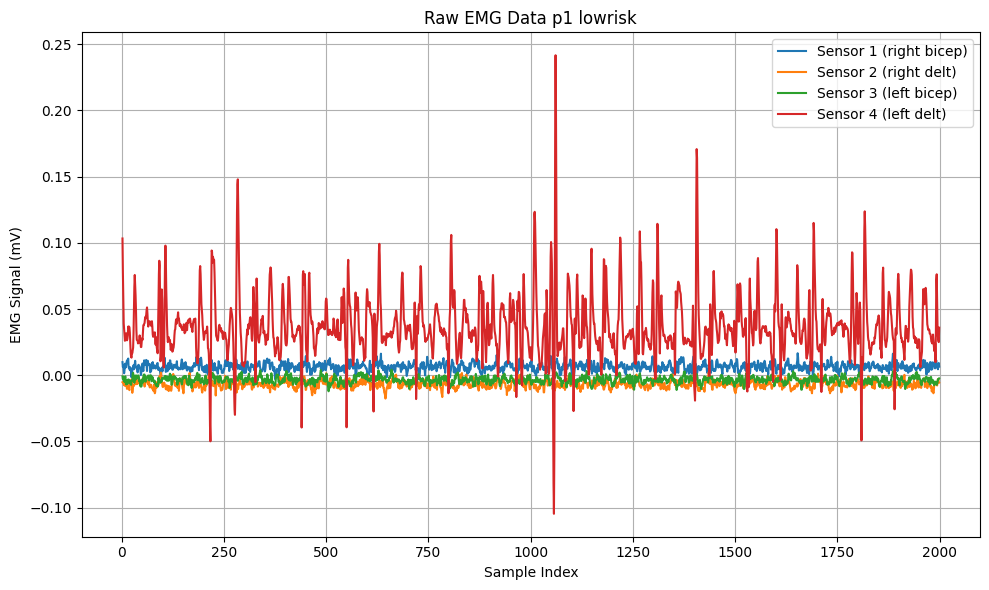

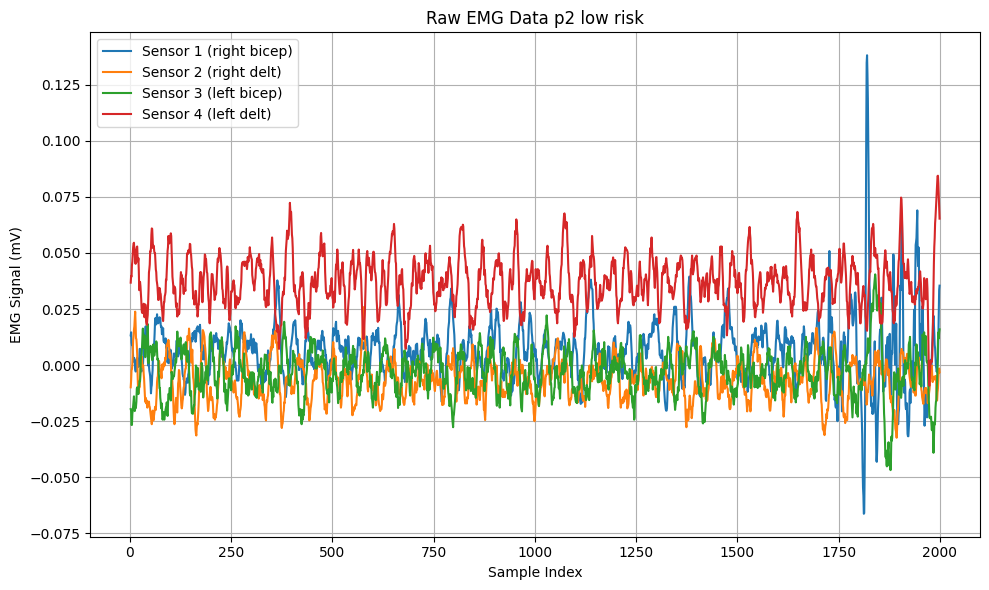

In [25]:
import matplotlib.pyplot as plt

emg_columns = [
        "Sensor 1 (right bicep)",
        "Sensor 2 (right delt)",
        "Sensor 3 (left bicep)",
        "Sensor 4 (left delt)"
    ]
def plot_raw_emg(df, title="Raw EMG Data", sample_range=2000):

    plt.figure(figsize=(10, 6))

    for i, col in enumerate(emg_columns):
        plt.plot(df[col][:sample_range], label=col)

    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("EMG Signal (mV)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_raw_emg(dfp1l, title="Raw EMG Data p1 lowrisk", sample_range=2000)
print("")
plot_raw_emg(dfp2l, title="Raw EMG Data p2 low risk", sample_range=2000)


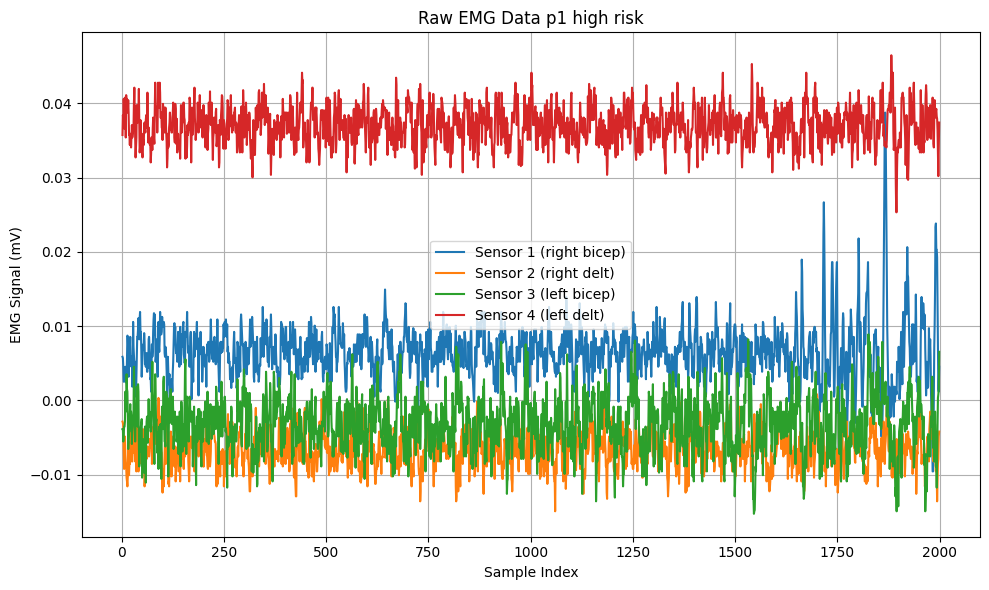

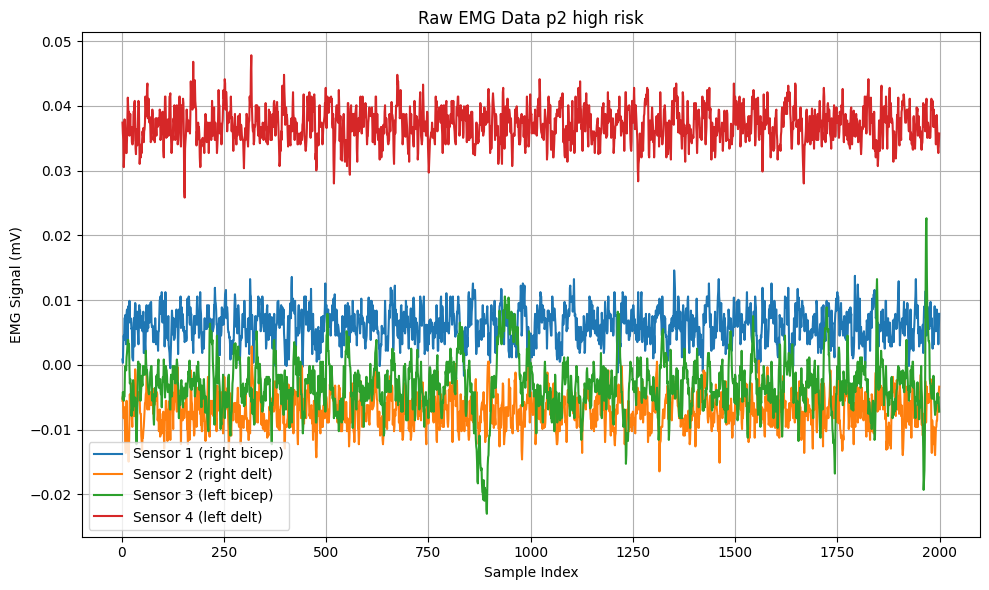

In [26]:
plot_raw_emg(dfp1h, title="Raw EMG Data p1 high risk", sample_range=2000)
print("")
plot_raw_emg(dfp2h, title="Raw EMG Data p2 high risk", sample_range=2000)


70-30 Train-Test

In [27]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

# 1. Instantiate & fit on your already-scaled feature arrays
clf = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
clf.fit(x_train, y_train)

# 2. Predict both labels and positive-class probabilities
y_pred  = clf.predict(x_test)
y_proba = clf.predict_proba(x_test)[:, 1]

# 3. Compute metrics
acc  = accuracy_score(y_test, y_pred)
cm   = confusion_matrix(y_test, y_pred)
crpt = classification_report(
    y_test, y_pred,
    target_names=["LowRisk", "HighRisk"],
    zero_division=0
)
auc  = roc_auc_score(y_test, y_proba)

# 4. Print results
print(f"Accuracy (70/30 split): {acc:.2%}\n")
print("Confusion Matrix:")
print(cm, "\n")
print("Classification Report:")
print(crpt)
mse  = mean_squared_error(y_test, y_proba)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_proba)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Accuracy (70/30 split): 57.70%

Confusion Matrix:
[[1030  951]
 [ 734 1268]] 

Classification Report:
              precision    recall  f1-score   support

     LowRisk       0.58      0.52      0.55      1981
    HighRisk       0.57      0.63      0.60      2002

    accuracy                           0.58      3983
   macro avg       0.58      0.58      0.58      3983
weighted avg       0.58      0.58      0.58      3983

Mean Squared Error (MSE): 0.25
Root Mean Squared Error (RMSE): 0.50
R² Score: 0.02


Logistic Regression model

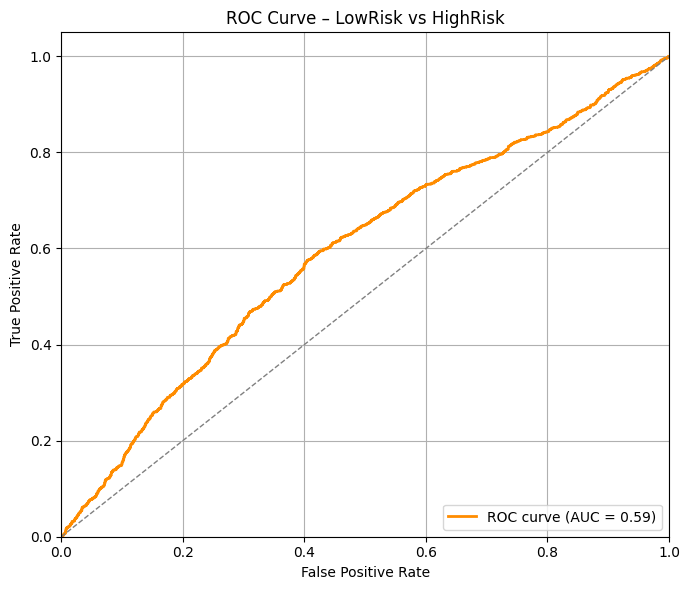

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#predicted probabilities for the positive class
y_prob = clf.predict_proba(x_test)[:, 1]

#FPR,TPR, and thresholds
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LowRisk vs HighRisk")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


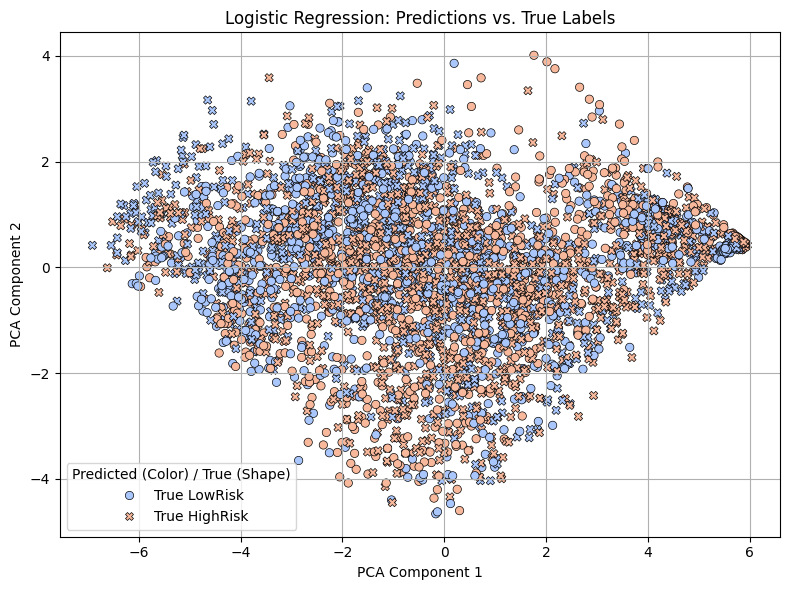

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_test)

pred_label = ['True LowRisk' if v==0 else 'True HighRisk' for v in y_pred]
true_label = ['True LowRisk' if v==0 else 'True HighRisk' for v in y_test]
#scatter scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    hue=pred_label,
    style=true_label,
    palette="coolwarm",
    edgecolor="black"
)

plt.title("Logistic Regression: Predictions vs. True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Predicted (Color) / True (Shape)")
plt.grid(True)
plt.tight_layout()
plt.show()


0 low risk
1 high risk
blue 0 correct low risk
red X correct high risk


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

#Random Forest Model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(x_train, y_train)

y_pred_rf = rf_clf.predict(x_test)

#Calculate classification metrics
acc_rf  = accuracy_score(y_test, y_pred_rf)
cm_rf   = confusion_matrix(y_test, y_pred_rf)
crpt_rf = classification_report(y_test, y_pred_rf, target_names=["LowRisk", "HighRisk"], zero_division=0)

#Calculate Regression metrics
mse_rf  = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

print(f"Accuracy (70/30 split): {acc_rf:.2f}\n")
print("Confusion Matrix:")
print(cm_rf, "\n")
print("Classification Report:")
print(crpt_rf, "\n")

print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"R² Score (Goodness of Fit): {r2_rf:.2f}")


Accuracy (70/30 split): 0.83

Confusion Matrix:
[[1682  299]
 [ 374 1628]] 

Classification Report:
              precision    recall  f1-score   support

     LowRisk       0.82      0.85      0.83      1981
    HighRisk       0.84      0.81      0.83      2002

    accuracy                           0.83      3983
   macro avg       0.83      0.83      0.83      3983
weighted avg       0.83      0.83      0.83      3983
 

Mean Squared Error (MSE): 0.17
Root Mean Squared Error (RMSE): 0.41
R² Score (Goodness of Fit): 0.32


TN:correctly classified LowRisk

FP: incorrectly classified LowRisk as HighRisk

FN: incorrectly classified HighRisk as LowRisk

TP: correctly classified HighRisk

TN  FP

FN  TP

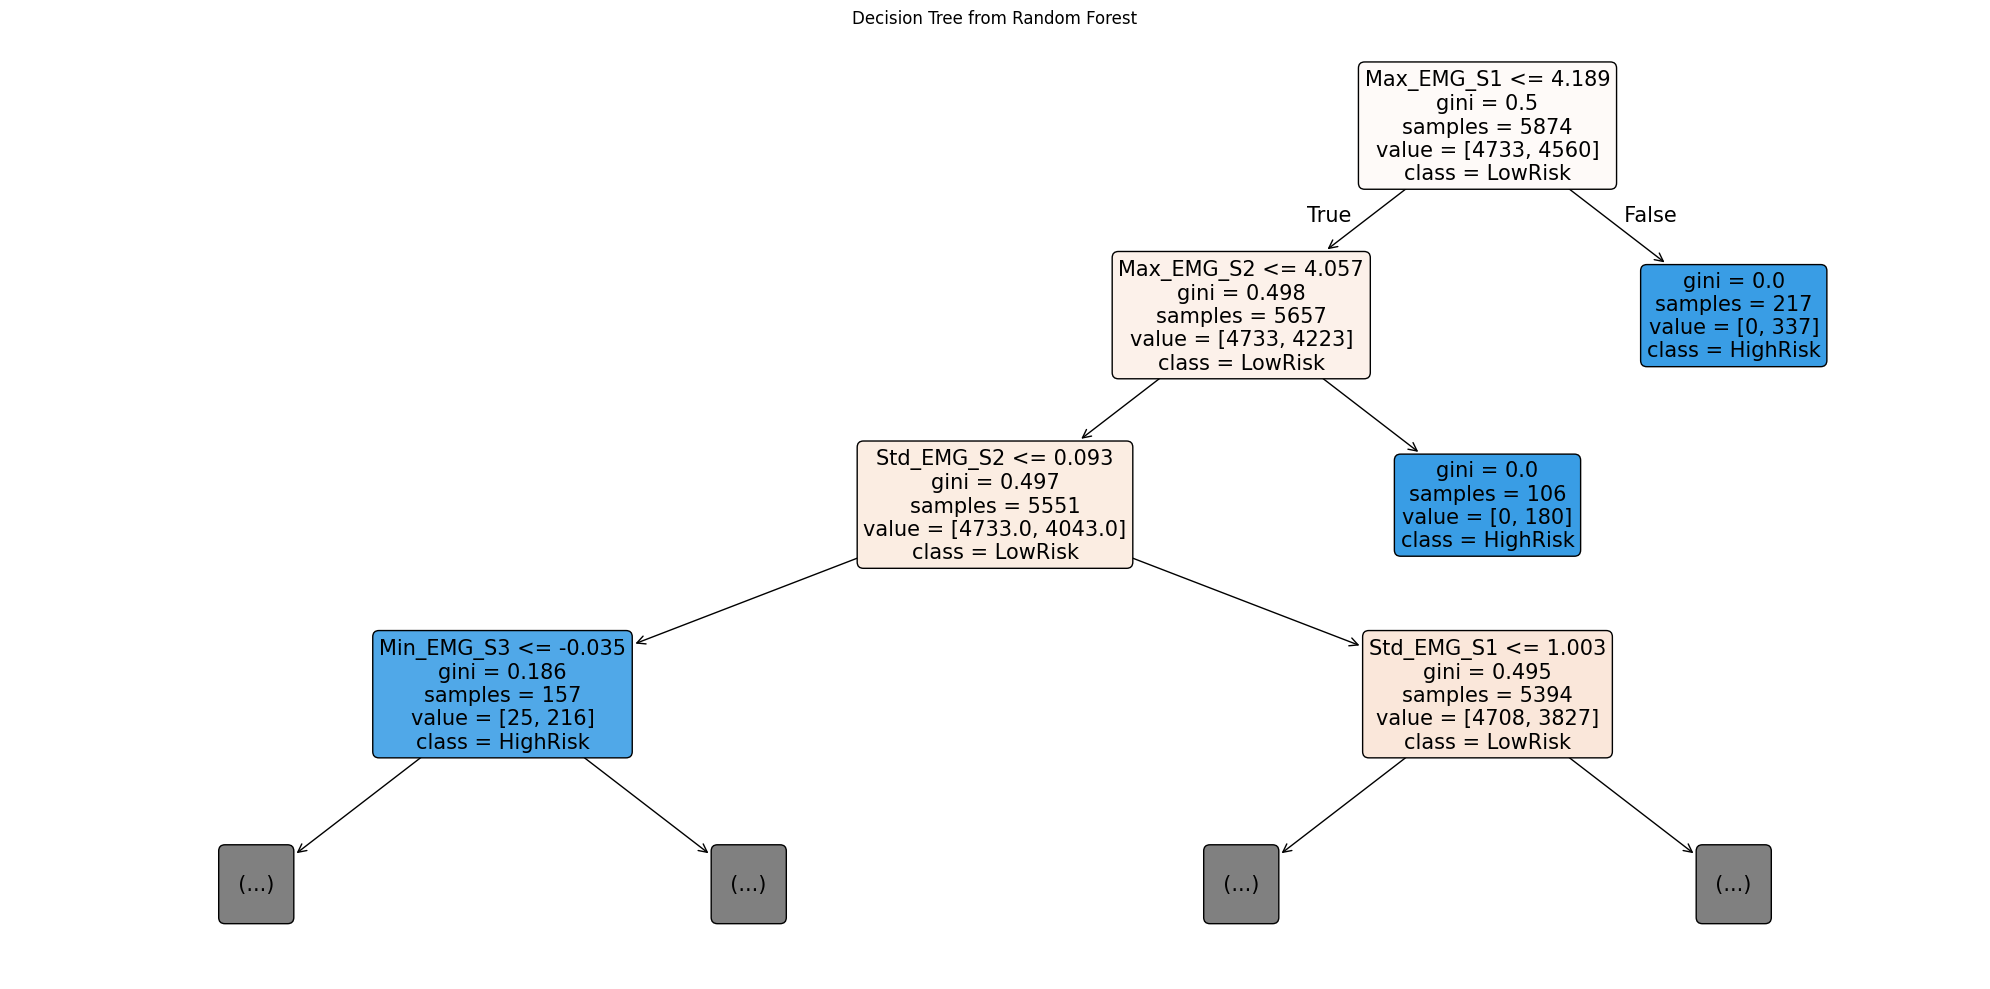

In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

#decision tree in the random forest
plt.figure(figsize=(20, 10))

plot_tree(
    rf_clf.estimators_[0],
    feature_names=X.columns,
    class_names=["LowRisk", "HighRisk"],
    filled=True,
    rounded=True,
    fontsize=15,
    max_depth=3
)

plt.title("Decision Tree from Random Forest")
plt.tight_layout()
plt.show()


decision tree for EMG

In [32]:
import numpy as np
import pandas as pd

def extract_rolling_imu_features(df: pd.DataFrame, window_size: int = 100, step_size: int = 30) -> pd.DataFrame:
    # Column names for IMU data
    acc_cols = [" ACC X (G)", " ACC Y (G)", " ACC Z (G)"]
    gyro_cols = [" GYRO X (deg/s)", " GYRO Y (deg/s)", " GYRO Z (deg/s)"]

    n_samples = df.shape[0]
    feature_rows = []

    for start in range(0, n_samples - window_size + 1, step_size):
        window = df.iloc[start : start + window_size]
        row_feats = []

        ax = window[" ACC X (G)"].to_numpy()
        ay = window[" ACC Y (G)"].to_numpy()
        az = window[" ACC Z (G)"].to_numpy()
        acc_mag = np.sqrt(ax**2 + ay**2 + az**2)

        peak_acc  = np.max(acc_mag) #max
        mean_acc  = np.mean(acc_mag) #mean
        total_acc = np.sum(acc_mag) #total acc
        range_acc = peak_acc - np.min(acc_mag) #range

        row_feats.extend([peak_acc, mean_acc, total_acc, range_acc])

        gx = window[" GYRO X (deg/s)"].to_numpy()
        gy = window[" GYRO Y (deg/s)"].to_numpy()
        gz = window[" GYRO Z (deg/s)"].to_numpy()
        gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)

        peak_gyro  = np.max(gyro_mag)
        mean_gyro  = np.mean(gyro_mag)
        total_gyro = np.sum(gyro_mag)
        range_gyro = peak_gyro - np.min(gyro_mag)

        row_feats.extend([peak_gyro, mean_gyro, total_gyro, range_gyro])

        feature_rows.append(row_feats)

    col_names = [
        "PeakAcc", "MeanAcc", "TotalAcc", "RangeAcc",
        "PeakGyro", "MeanGyro", "TotalGyro", "RangeGyro"
    ]

    return pd.DataFrame(feature_rows, columns=col_names)



In [33]:
dfs = []  # Empty list to collect feature DataFrame from each trial

# Loop over each trial paired with its label (0 = Low Risk, 1 = High Risk)
for df_trial, label in [
    (dfp1l, 0),  # LowRisk
    (dfp1h, 1),  # HighRisk
    (dfp2l, 0),  # LowRisk
    (dfp2h, 1)   # HighRisk
]:
    # Extract rolling window IMU features for this trial
    feats = extract_rolling_imu_features(df_trial)
    # Add a new column called "Label" for classification
    feats["Label"] = label
    # Append the labeled feature DataFrame to the list
    dfs.append(feats)

# Concatenate all trial DataFrames into one, resetting indices
full_df = pd.concat(dfs, ignore_index=True)

# Separate features (X) and labels (y)
X = full_df.drop(columns=["Label"])
y = full_df["Label"].values


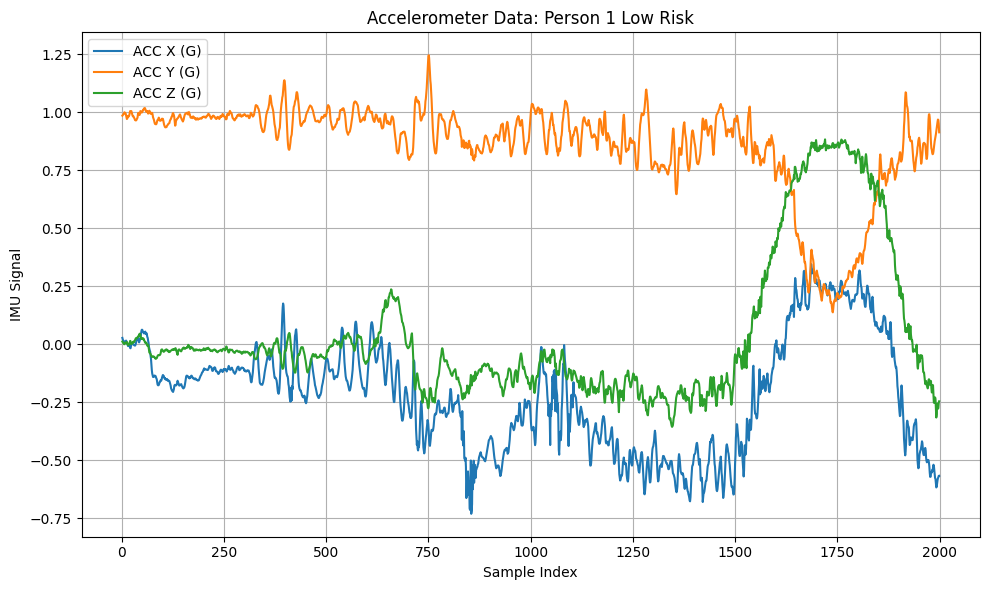

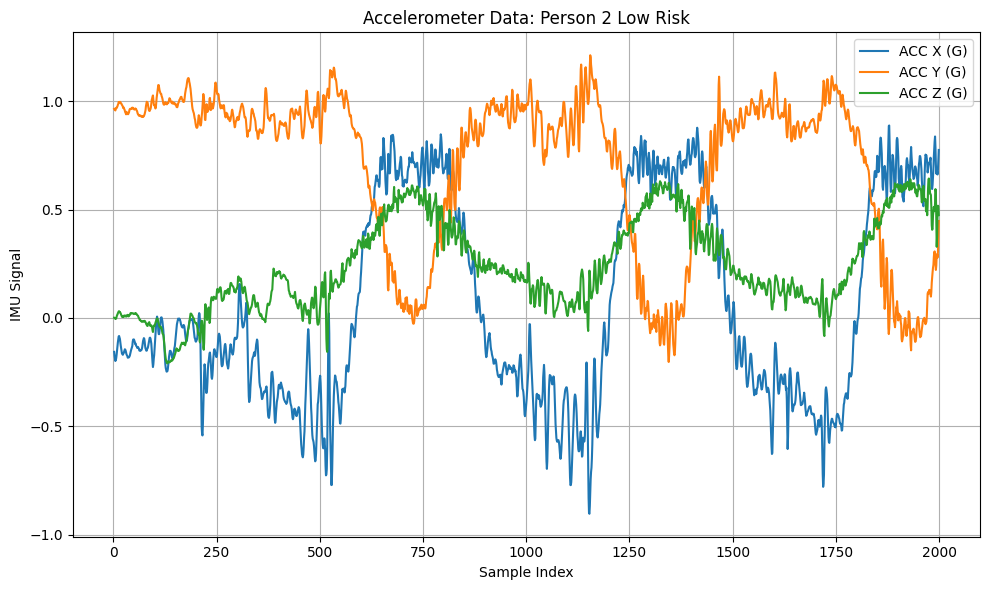

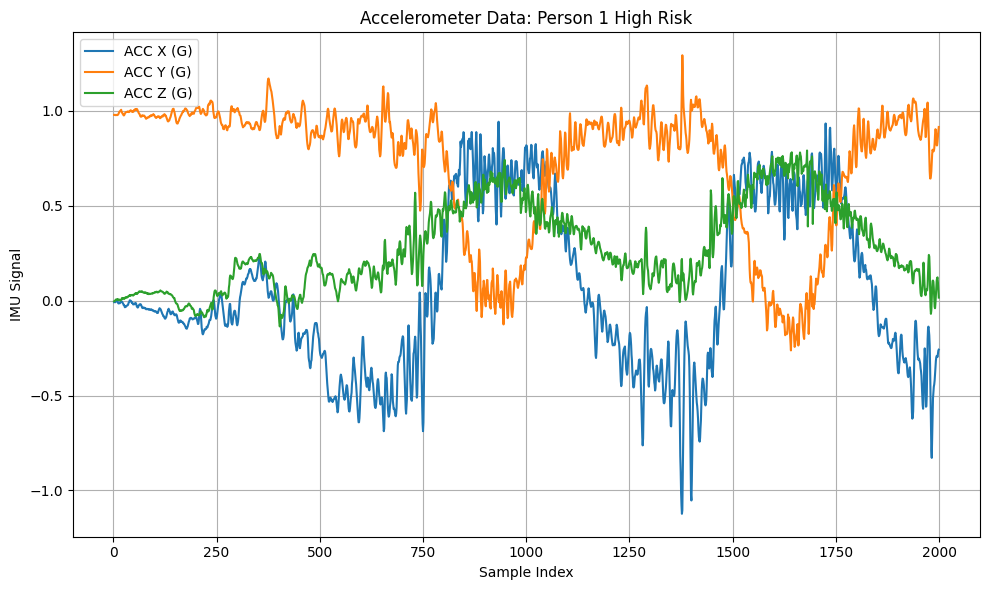

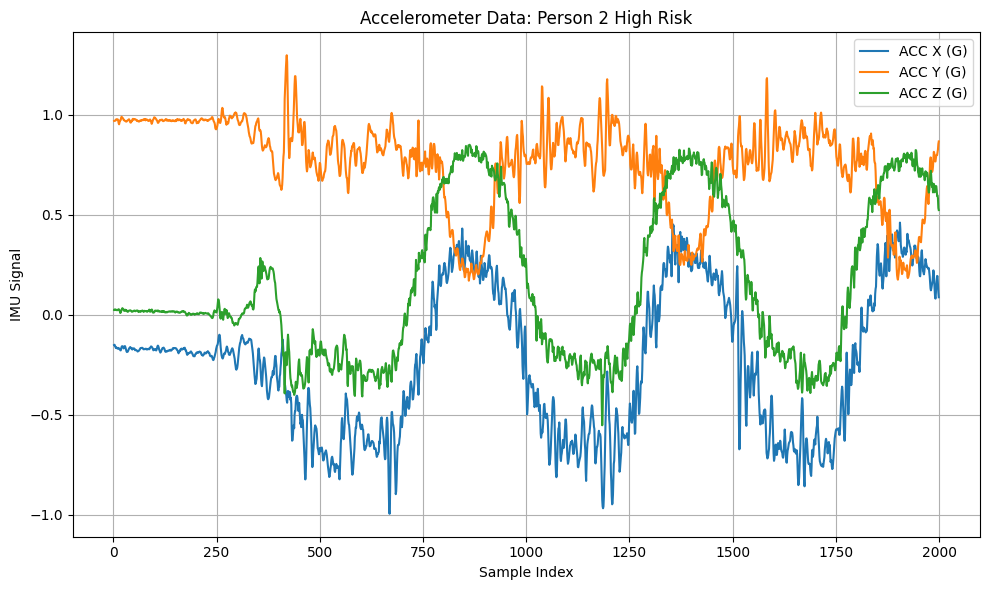

In [34]:
import matplotlib.pyplot as plt

def plot_acc(df, title="ACC Graph", sample_range=2000):
    acc_cols  = [" ACC X (G)", " ACC Y (G)", " ACC Z (G)"]

    plt.figure(figsize=(10, 6))

    # Plot accelerometer data
    for col in acc_cols:
        plt.plot(df[col][:sample_range], label=col.strip())

    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("IMU Signal")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_acc(dfp1l, title="Accelerometer Data: Person 1 Low Risk", sample_range=2000)
plot_acc(dfp2l, title="Accelerometer Data: Person 2 Low Risk", sample_range=2000)
plot_acc(dfp1h, title="Accelerometer Data: Person 1 High Risk", sample_range=2000)
plot_acc(dfp2h, title="Accelerometer Data: Person 2 High Risk", sample_range=2000)


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics      import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    mean_squared_error,
    r2_score
)
import numpy as np

# Fill any missing feature‐values (this is on your feature matrix, not the raw signals)
X_filled = X.fillna(X.mean())

# 2) Create a 70/30 train–test split
x_train, x_test, y_train, y_test = train_test_split(
    X_filled, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# 3) Train a Random Forest on those features
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)

# 4) Predict on the held‐out test set
y_pred = clf.predict(x_test)

# 5) Compute classification metrics
acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred, zero_division=0)
rec   = recall_score(y_test, y_pred, zero_division=0)
f1    = f1_score(y_test, y_pred, zero_division=0)
cm    = confusion_matrix(y_test, y_pred)
report = classification_report(
    y_test, y_pred,
    target_names=["LowRisk", "HighRisk"],
    zero_division=0
)

mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred)

# 7) Print results
print(f"Accuracy       : {acc:.2f}")
print(f"Precision      : {prec:.2f}")
print(f"Recall         : {rec:.2f}")
print(f"F1 Score       : {f1:.2f}\n")

print("Confusion Matrix:")
print(cm, "\n")

print("Classification Report:")
print(report)

print(f"Mean Squared Error (MSE)   : {mse:.2f}")
print(f"Root Mean Squared Error    : {rmse:.2f}")
print(f"R² Score (Goodness of Fit) : {r2:.2f}")



Accuracy       : 0.53
Precision      : 0.52
Recall         : 0.98
F1 Score       : 0.68

Confusion Matrix:
[[ 176 1958]
 [  43 2105]] 

Classification Report:
              precision    recall  f1-score   support

     LowRisk       0.80      0.08      0.15      2134
    HighRisk       0.52      0.98      0.68      2148

    accuracy                           0.53      4282
   macro avg       0.66      0.53      0.41      4282
weighted avg       0.66      0.53      0.41      4282

Mean Squared Error (MSE)   : 0.47
Root Mean Squared Error    : 0.68
R² Score (Goodness of Fit) : -0.87


everything is predicted as LowRisk

Feature summary statistics

In [36]:
raw_all = pd.concat([dfp1h, dfp1l, dfp2h, dfp2l], ignore_index=True)
summary = pd.DataFrame({
    "Feature": emg_columns,
    "Mean":    raw_all[emg_columns].mean().values,
    "Std":     raw_all[emg_columns].std().values,
    "Range":   (raw_all[emg_columns].max() - raw_all[emg_columns].min()).values
})
print(summary.to_string(index=False))
imu_cols = [c for c in raw_all.columns if 'ACC' in c or 'GYRO' in c]
summary_imu = pd.DataFrame({
    'Feature': imu_cols,
    'Mean':    raw_all[imu_cols].mean().values,
    'Std':     raw_all[imu_cols].std().values,
    'Range':   (raw_all[imu_cols].max() - raw_all[imu_cols].min()).values
})

print("=== IMU Summary Statistics ===")
print(summary_imu.to_string(index=False))

               Feature      Mean      Std     Range
Sensor 1 (right bicep)  0.006418 0.053738  1.754360
 Sensor 2 (right delt) -0.006737 0.050177  5.106645
 Sensor 3 (left bicep) -0.003222 0.199247 10.318364
  Sensor 4 (left delt)  0.037026 0.178490  4.671916
=== IMU Summary Statistics ===
                  Feature       Mean       Std      Range
    ACC X Time Series (s)  43.058614 25.457337  98.408250
                ACC X (G)  -0.082973  0.458236   2.363708
    ACC Y Time Series (s)  43.058614 25.457337  98.408250
                ACC Y (G)   0.712502  0.306582   1.721802
    ACC Z Time Series (s)  43.058614 25.457337  98.408250
                ACC Z (G)   0.233503  0.318347   1.502258
   GYRO X Time Series (s)  43.058614 25.457337  98.408250
           GYRO X (deg/s) -17.449205 37.791250 267.725189
   GYRO Y Time Series (s)  43.058614 25.457337  98.408250
           GYRO Y (deg/s)   0.251598 39.840211 421.633591
   GYRO Z Time Series (s)  43.058614 25.457337  98.408250
           GY